# Pegasus Quickstart

Welcome to the Pegasus Quickstart tutorial notebook, which is intended for new users who want to get a quick overview of Pegasus concepts and usage. This quickstart tutorial notebook covers:

 - Using the Pegasus API to generate an abstract workflow
 - Using the API to plan the abstract workflow into an executable workflow
 - Run the workflow first locally, and then have the jobs in the workflow run on remote ACCESS resources.
 
For a quick overview of Pegasus, please see this short YouTube video:

[![A 5 Minute Introduction](../images/youtube-pegasus-intro.png)](https://www.youtube.com/watch?v=MNN80OHMQUQ "A 5 Minute Introduction")


In later notebooks, we will introduce additional concepts on how to specify remote datasets, describe how you can package your software in containers to use for your jobs, describe site layout for resources, run a LLM RAG workflow

- 01 - Quickstart	(this one) 
- 02 - Data		 
- 03 - Software			 
- 04 - Site-Layout
- 05 - LLM-RAG-Workflow 
- 05 - Workflow-API
- 06 - Debugging / Statistics
- 07 - Provisioning
- 08 - Using Shared Fileystem on ACCESS Resource

## Hello World Workflow

This notebook will generate a simple **Hello World** workflow illustrated below, then plan and execute the workflow. We will first run this workflow locally on the ACCESS Pegasus host, and then run on the remote ACCESS resources.

Rectangles represent input/output files, and ovals represent compute jobs. The arrows represent file dependencies between each compute job. This simple workflow will execute 2 jobs, each taking in one input file and generating a single output file. The **world** job is dependant on the output of the **hello**.

Each job in this workflow invokes a python executable named *hello* and *world* . These are symlinks to the same executable *pegasus-keg.py* . We use symbolic links in this case, to have the executable and the job name match. The python code is a simple code that takes in an input file; captures the hostname of the node where it is run on; and also includes the contents of the input file in it's output.

![Hello World Workflow](../images/pipeline.svg)

The abstract workflow description that you specify to Pegasus is portable, and usually does not contain any locations to physical input files, executables or cluster end points where jobs are executed. 

In this example, Pegasus will 

* pick up the inputs from a directory named **input** .
* pick up the executables from a directory named **executables** .
* place the generated outputs in a directory named **output** .


<div class="alert alert-block alert-info">
<b>Note:</b> There is a separation between the environment where this notebook runs and where the compute job executes. This notebook runs on pegasus.access-ci.org, while the job is executed on any available HTCondor execution points. For this tutorial, a small number of execution points will be provided automatically. For larger workflows, you will learn in the `Provisioning` tutorial how to allocate additional resources using your allocations.
</div>


## 1. Import Python API

Pegasus 5.0 introduces a new Python API, which is fully documented in the [Pegasus reference guide](https://pegasus.isi.edu/documentation/reference-guide/api-reference.html). 

We will mainly use 3 main classes in this simple quickstart example

<br>

```
from Pegasus.api.replica_catalog import File
from Pegasus.api.workflow import Job, Workflow
from Pegasus.client._client import PegasusClientError
```

The `Workflow` object is used to store jobs and dependencies between each job. Typical job creation is as follows:

```
# Define job Input/Output files
input_file = File("input.txt")
output_file1 = File("output1.txt")
output_file2 = File("output2.txt")

# Define job, passing in the transformation (executable) it will use
j = Job(transformation_obj)

# Specify command line arguments (if any) which will be passed to the transformation when run
j.add_args("arg1", "arg2", input_file, "arg3", output_file)

# Specify input files (if any)
j.add_inputs(input_file)

# Specify output files (if any)
j.add_outputs(output_file1, output_file2)

# Add profiles to the job
j.add_env(FOO="bar")
j.add_profiles(Namespace.PEGASUS, key="checkpoint.time", value=1)

# Add the job to the workflow object
wf.add_jobs(j)
```

By default, dependencies between jobs are inferred based on input and output files. 

In [1]:
from Pegasus.api import *
import sys
from pathlib import Path

import logging

logging.basicConfig(level=logging.DEBUG)

# we specify directories for inputs, executables and outputs
# - directory where to pick up the inputs from a directory.
# - directory where the executables that the workflow uses are placed.
# - directory where the outputs should be placed.

BASE_DIR = Path(".").resolve()
INPUT_DIR = Path(BASE_DIR /  "input").resolve()
EXECUTABLES_DIR = Path(BASE_DIR / ".." /  "executables").resolve()
OUTPUT_DIR = Path(BASE_DIR /  "output").resolve() 

# the execution site where you job to run.
# local means the jobs run on ACCESS Pegasus itself.
# condorpool means jobs will run on a node provisioned from an ACCESS site such as jetstream
EXEC_SITE="local"

# generate a simple input file for the workflow
with open("{}/f.in".format(INPUT_DIR), "w") as f:
    f.write("This is the contents of the input file for the hello world workflow!")

# --- Workflow -----------------------------------------------------------------
wf = Workflow("hello-world")

fin = File("f.in")
finter = File("f.inter")
fout = File("f.out")

job_hello = Job("hello")\
                    .add_args("-T", "3", "-i", fin, "-o {}".format(finter))\
                    .add_inputs(fin)\
                    .add_outputs(finter, stage_out=False)

job_world = Job("world")\
                    .add_args("-T", "3", "-i", finter, "-o {}".format(fout))\
                    .add_inputs(finter)\
                    .add_outputs(fout)

wf.add_jobs(job_hello, job_world)    

# --- Visualize the Workflow ---------------------------------------------------
try:
    wf.write()
    wf.graph(include_files=True, label="xform-id", output="graph.png")
except PegasusClientError as e:
    print(e)

INFO:Pegasus.api.workflow:hello-world added Job(_id=ID0000001, transformation=hello)
INFO:Pegasus.api.workflow:hello-world added Job(_id=ID0000002, transformation=world)
INFO:Pegasus.api.workflow:inferring hello-world dependencies
INFO:Pegasus.api.workflow:workflow hello-world with 2 jobs generated and written to workflow.yml

####################
# pegasus-graphviz #
####################


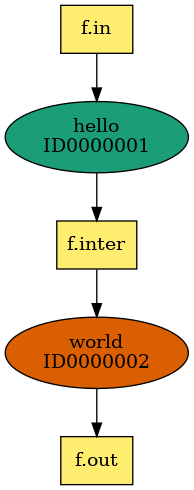

In [2]:
# view rendered workflow
from IPython.display import Image
Image(filename='graph.png')

## 2. Run the Workflow

When working in Python, we can just use the reference do the `Workflow` object, you can plan, run, and monitor the workflow directly. These are wrappers around Pegasus CLI tools, and as such, the same arguments may be passed to them. 

In [3]:
try:
    wf.plan(input_dirs=[INPUT_DIR], sites=[EXEC_SITE], transformations_dir=EXECUTABLES_DIR,\
            output_dir=OUTPUT_DIR, submit=True)
except PegasusClientError as e:
    print(e)



################
# pegasus-plan #
################
2025.11.13 19:11:05.357 UTC:
2025.11.13 19:11:05.363 UTC:   -----------------------------------------------------------------------
2025.11.13 19:11:05.368 UTC:   File for submitting this DAG to HTCondor           : hello-world-0.dag.condor.sub
2025.11.13 19:11:05.373 UTC:   Log of DAGMan debugging messages                   : hello-world-0.dag.dagman.out
2025.11.13 19:11:05.379 UTC:   Log of HTCondor library output                     : hello-world-0.dag.lib.out
2025.11.13 19:11:05.384 UTC:   Log of HTCondor library error messages             : hello-world-0.dag.lib.err
2025.11.13 19:11:05.389 UTC:   Log of the life of condor_dagman itself            : hello-world-0.dag.dagman.log
2025.11.13 19:11:05.394 UTC:
2025.11.13 19:11:05.400 UTC:   -no_submit given, not submitting DAG to HTCondor. You can do this with:
2025.11.13 19:11:05.410 UTC:   -----------------------------------------------------------------------
2025.11.13 19:11:07.29

Note the line in the output that starts with pegasus-status, contains the command you can use to monitor the status of the workflow. We will cover this command line tool in the next couple of notbooks. The path it contains is the path to the submit directory where all of the files required to submit and monitor the workflow are stored. For now we will just continue to use the Python `Workflow` object

In [4]:
wf.status(long=True)


   ID        SITE      STAT  IN_STATE  JOB                      
1993738      local      Run    00:16   hello-world-0 (/home/vahi/ACCESS-Pegasus-Examples/01-Quickstart/vahi/pegasus/hello-world/run0001)
Summary: 1 Condor job total (R:1)

UNREADY READY  PRE  IN_Q  POST  DONE  FAIL %DONE  STATE  DAGNAME                  
   9      2     0    0     0     1     0    8.33 Running hello-world-0.dag        
Summary: 1 DAG total (Running:1)


Wait for the workflow to finish, and then display the results

We can also just block on the workflow finishing:

In [5]:
wf.wait()

[#########################] 100.0% ..Success (Unready: 0, Completed: 12, Queued: 0, Running: 0, Failed: 0)


## 3. Inspecting the generated output of the workflow

The executable that is run as part of this worklfow, is a simple python script that captures the hostname, where
a job ran, and also includes the contents of the input file in it's output.

The Hostname in the .out file indicates that the jobs ran on pegasus.access-ci.org. 


In [6]:
! cat output/f.out

===================== contents start f.out =====================
Hostname: pegasus.access-ci.org IP Addr: 10.1.214.25
	--- start f.inter ----
	===================== contents start f.inter =====================

	Hostname: pegasus.access-ci.org IP Addr: 10.1.214.25

		--- start f.in ----

		This is the contents of the input file for the hello world workflow!

		--- end f.in ----

	===================== contents end   f.inter =====================

	--- end f.inter ----
===================== contents end   f.out =====================


##  4. Statistics

Depending on if the workflow finished successfully or not, you have options on what to do next. If the workflow failed you can use `wf.analyze()` do get help finding out what went wrong. If the workflow finished successfully, we can pull out some statistcs from the provenance database:

In [7]:
try:
    wf.statistics()
except PegasusClientError as e:
    print(e)


######################
# pegasus-statistics #
######################
#
# Pegasus Workflow Management System - https://pegasus.isi.edu
#
# Workflow summary:
#   Summary of the workflow execution. It shows total
#   tasks/jobs/sub workflows run, how many succeeded/failed etc.
#   In case of hierarchical workflow the calculation shows the
#   statistics across all the sub workflows.It shows the following
#   statistics about tasks, jobs and sub workflows.
#     * Succeeded - total count of succeeded tasks/jobs/sub workflows.
#     * Failed - total count of failed tasks/jobs/sub workflows.
#     * Incomplete - total count of tasks/jobs/sub workflows that are
#       not in succeeded or failed state. This includes all the jobs
#       that are not submitted, submitted but not completed etc. This
#       is calculated as  difference between 'total' count and sum of
#       'succeeded' and 'failed' count.
#     * Total - total count of tasks/jobs/sub workflows.
#     * Retries - total retry 

##  5. Run the jobs in the workflow on ACCESS resources

Since we planned the workflow for a site named **local** the jobs ran on ACCESS Pegasus host itself.

Now we will plan the same workflow again and have it run on a site named **condorpool**.

Note, that we are not re-defining the workflow. The workflow to Pegasus is described in a portable resource agnostic way. We are taking the same abstract workflow and now, will replan it for a different execution environment.

<div class="alert alert-block alert-info">
<b>Note:</b> There is a separation between the environment where this notebook runs and where the compute job executes. This notebook runs on pegasus.access-ci.org, while the job is executed on any available HTCondor execution points. For this tutorial, a small number of execution points will be provided automatically. For larger workflows, you will learn in the `Provisioning` tutorial how to allocate additional resources using your allocations.
The following figure shows how workflows are defined using the Pegasus API in Jupyter, planned to an executable
HTCondor DAGMan, and jobs flow to the remote execution sites (TestPool in this case).
</div>

<img src="../images/access-pegasus-jobflow.png"/>

In [8]:
try:
    wf.plan(input_dirs=[INPUT_DIR], sites=["condorpool"], transformations_dir=EXECUTABLES_DIR,\
            output_dir=OUTPUT_DIR, submit=True)\
      .wait()
except PegasusClientError as e:
    print(e)


################
# pegasus-plan #
################
2025.11.13 19:14:43.089 UTC:
2025.11.13 19:14:43.094 UTC:   -----------------------------------------------------------------------
2025.11.13 19:14:43.100 UTC:   File for submitting this DAG to HTCondor           : hello-world-0.dag.condor.sub
2025.11.13 19:14:43.105 UTC:   Log of DAGMan debugging messages                   : hello-world-0.dag.dagman.out
2025.11.13 19:14:43.110 UTC:   Log of HTCondor library output                     : hello-world-0.dag.lib.out
2025.11.13 19:14:43.115 UTC:   Log of HTCondor library error messages             : hello-world-0.dag.lib.err
2025.11.13 19:14:43.120 UTC:   Log of the life of condor_dagman itself            : hello-world-0.dag.dagman.log
2025.11.13 19:14:43.126 UTC:
2025.11.13 19:14:43.131 UTC:   -no_submit given, not submitting DAG to HTCondor. You can do this with:
2025.11.13 19:14:43.141 UTC:   -----------------------------------------------------------------------
2025.11.13 19:14:45.04

[#########################] 100.0% ..Success (Unready: 0, Completed: 12, Queued: 0, Running: 0, Failed: 0)


### 5.1 Reinspecting the output of the workflow 

Now lets review the output of the workflow to check where the jobs ran. The displayed hostname will have a prefix of  testpool-cpu-* . The test pool is made of nodes provisioned from the Indiana University's **Jetstream2** which is a Cloud ACCESS resource.

In [9]:
! cat output/f.out

===================== contents start f.out =====================
Hostname: testpool-cpu-vahi-20251113191527.novalocal IP Addr: 10.2.254.85
	--- start f.inter ----
	===================== contents start f.inter =====================

	Hostname: testpool-cpu-vahi-20251113191527.novalocal IP Addr: 10.2.254.85

		--- start f.in ----

		This is the contents of the input file for the hello world workflow!

		--- end f.in ----

	===================== contents end   f.inter =====================

	--- end f.inter ----
===================== contents end   f.out =====================


## What's Next?

To continue exploring Pegasus, the next tutorial notebook  will build on the workflow you just executed. Instead of grabbing the input data from a local directory, we will explore how  specify a remote files as inputs to the workflow